In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


AdaBoost and random forest are usually effective method to choose when there is significant data imbalance. After some research, I constructed a random forest model, using grid search and cross validation to find suitable parameters, and used the random forest as a base learner for AdaBoost model. The results of accuracy and precision are the best so far.

## Load data

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Redback_B/Heart_2022/heart_2022_no_nans.csv')

In [ ]:
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


## Preprocess data

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into majority class ('No') and minority class ('Yes')
df_majority = df[df['HadHeartAttack'] == 'No']
df_minority = df[df['HadHeartAttack'] == 'Yes']

fraction_to_keep = 0.4
# 0.4 is the best fraction I found after running several attempts.

# Randomly sample a portion
df_majority_sampled = df_majority.sample(frac=fraction_to_keep, random_state=42)

# Combine the two to make a balanced dataset
df_balanced = pd.concat([df_minority, df_majority_sampled])

# Shuffle the rows
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df = df_balanced.copy()

## Model Data

In [ ]:
# Import the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

# Define X and y
y = df.HadHeartAttack
X = df.drop('HadHeartAttack', axis=1)

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=456)

In [ ]:
# Convert target variable into numbers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

def preprocess_data(X_train, X_test):
    # Separate numerical and categorical columns
    numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
    categorical_columns = X_train.select_dtypes(include=['object']).columns

    # Normalize numerical data using StandardScaler
    scaler = StandardScaler()
    X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
    X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

    # Apply LabelEncoder to categorical data
    label_encoder = LabelEncoder()
    for column in categorical_columns:
        X_train[column] = label_encoder.fit_transform(X_train[column])
        X_test[column] = label_encoder.transform(X_test[column])

    return X_train, X_test

X_train_processed, X_test_processed = preprocess_data(X_train.copy(), X_test.copy())

In [ ]:
import time

# Start the timer
start_time = time.time()

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Create an instance of Random Forest Classifier
rf = RandomForestClassifier()

# Set the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2']
}

# Use GridSearchCV to search over the parameter grid and find the best parameter values
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=3)
grid_search.fit(X_train_processed, y_train)

# Print the best parameter values
print("Best parameters: ", grid_search.best_params_)

# Use the best parameter values to create a Random Forest classifier
best_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)

# Perform cross-validation on the training set
cv_scores_rf = cross_val_score(best_rf, X_train_processed, y_train, cv=3)

# Print the cross-validation scores
print("Parameter values of best_rf: ", best_rf.get_params())
print("Cross-validation scores for Random Forest:", cv_scores_rf)

Best parameters:  {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Parameter values of best_rf:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Cross-validation scores for Random Forest: [0.90596949 0.90621101 0.90713682]


In [ ]:
# Use the best_rf as the base learner for AdaBoost
adaboost_classifier_rf = AdaBoostClassifier(best_rf, n_estimators=50)

# Train the model
adaboost_classifier_rf.fit(X_train_processed, y_train)

# Make predictions
y_predicted = adaboost_classifier_rf.predict(X_test_processed)

In [ ]:
# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Print the elapsed time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))

Elapsed time: 1434.23 seconds


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Accuracy
accuracy = accuracy_score(y_test, y_predicted)

# Precision
precision = precision_score(y_test, y_predicted)

# Recall
recall = recall_score(y_test, y_predicted)

# F1 Score
f1 = f1_score(y_test, y_predicted)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9023
Precision: 0.7048
Recall: 0.3885
F1 Score: 0.5009


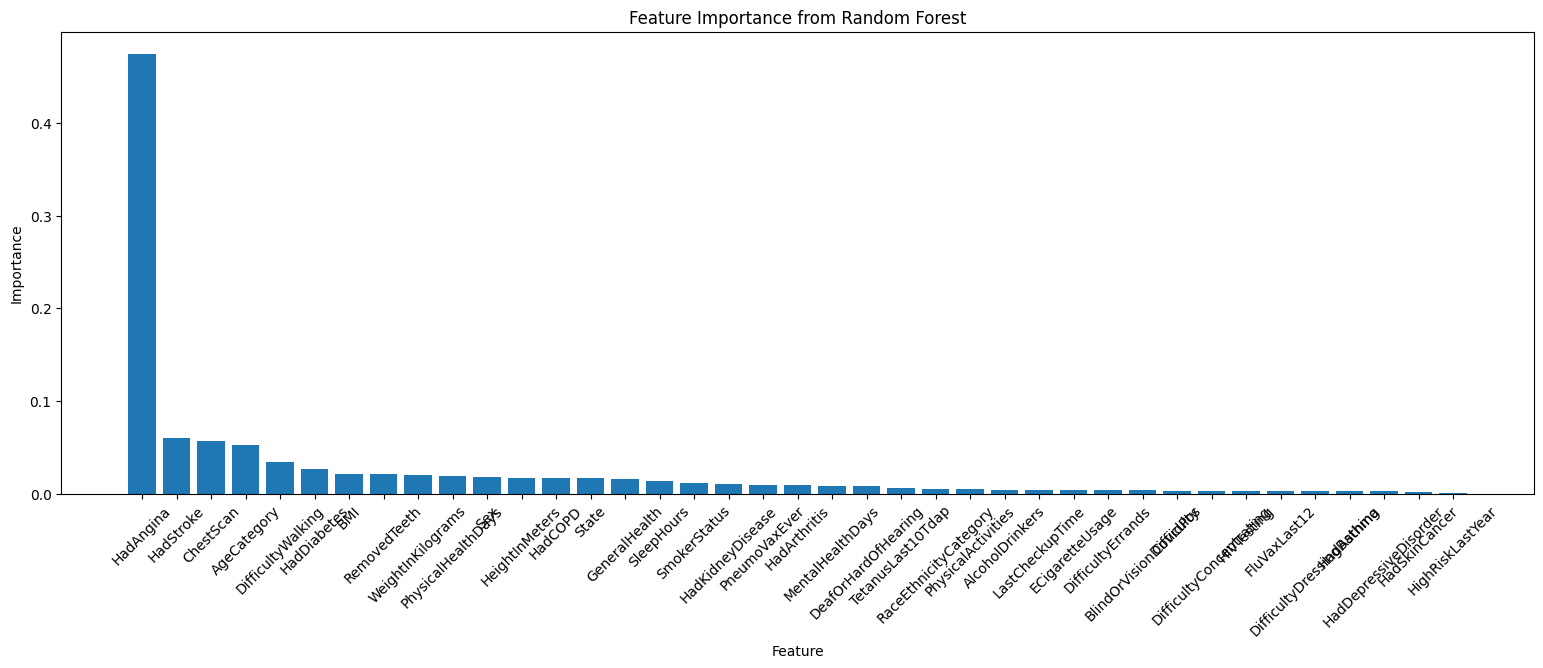

In [ ]:
import matplotlib.pyplot as plt

best_rf.fit(X_train_processed, y_train)

# Get feature importances
feature_importances = best_rf.feature_importances_

# Sort features in descending order of importance
import numpy as np
indices = np.argsort(feature_importances)[::-1]

# Get the feature names
feature_names = X_train_processed.columns

# Plot the feature importances
plt.figure(figsize=(19, 6))
plt.bar(range(X_train_processed.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train_processed.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.show()